# Plot and Filter Contaminants Across Data Sets

- want to loop over different sample types within project
- From merged, project specific dataset files
- Export and Save Files
- collapseNoMismatch processed data (Dada2 program)

### Imports

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import glob

#For illustrator import:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
# Libraries to not include:
#  drop_libs = ['AC', 'AD', 'AH']
prefix = 'CN19S'

### Functions

In [9]:
# Dada2 Banzai Output Functions
levels = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']

def make_metadata(infile):
    df = pd.read_csv(infile)
    df.set_index('sample_name', inplace=True)
    return df

#Raw Read Numbers
def make_taxa_otu_tables(infile):
    #infile = ASV_taxa_table_all.csv
    df = pd.read_csv(infile, sep=',')
    df.set_index('ASV', inplace=True)
    otu_table = df.drop(levels, axis=1)
    taxa_table = df[levels]
    return otu_table, taxa_table

#From fasta file create pandas df of ASV and sequence
def from_fasta_to_df(file):
    print(file)
    with open(file) as f:
        Ids=[]
        seqs =[]
        for strline in f:
            if strline[0]=='>':
                Ids.append(strline[1:].strip())
            else:
                seqs.append(strline.strip())
    print('Number of Ids:',len(Ids))
    print('Number of Seqs:',len(seqs))
    seq_dict = dict(zip(Ids, seqs))
    #make pandas df
    df= pd.DataFrame.from_dict(seq_dict,orient='index', columns=['sequence'])
    return df

#from metadata file, limit OTU table and taxa table to those present in those samples
def from_metadata_to_taxareads(meta_data, otu_table, taxa_table):
    #standard M6 output; sample_names as index; OTUs as index
    cols = list(meta_data)
    otu_lim = pd.concat([meta_data, otu_table.T],join='inner', axis=1)
    otu_lim.drop(cols, inplace=True, axis=1)
    otu_lim=otu_lim.T
    otu_lim['Total']=otu_lim.sum(axis=1)
    otu_lim = otu_lim.loc[otu_lim['Total']>0]
    otu_lim.drop('Total', axis=1, inplace=True)
    cols=list(otu_lim)
    taxa_lim=pd.concat([otu_lim, taxa_table], axis=1, join='inner')
    taxa_lim.drop(cols, inplace=True, axis=1)
    return otu_lim, taxa_lim

def from_taxa_to_otutab(taxa_table, otu_table):
    #remove OTUs not in the taxa table
    otu_lim = pd.concat([taxa_table, otu_table],join='inner', axis=1)
    otu_lim.drop(levels, inplace=True, axis=1)
    return otu_lim

#Plot number of reads in controls
#By Species
def OTUs_in_controls_plot(otu_tab, taxa_tab, meta_data):
    from palettable.tableau import Tableau_20 as pr
    cmap=pr.mpl_colormap
    #define control samples by non-environmental samples
    df=meta_data.copy()
    grouped = ['Kingdom', 'Phylum', 'Class', 'Order']
    #grouped= ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
    df = df.loc[df['sample_type']!='environmental']
    df = df.loc[df['sample_type']!='positive']
    controls = df.index.tolist()
    print('controls:', controls)
    df=df.sort_index()
    df=df[['library','sample_type', 'target_gene']]
    #Now look at reads in controls
    df= pd.concat([df, otu_tab.T], axis=1,join='inner')
    df.index.name = 'sample_name'
    df=df.reset_index().set_index(['sample_name', 'library','sample_type','target_gene'])
    df=df.T
    df['Tot'] = df.sum(axis=1)
    df=df.loc[df['Tot']>0]
    col_name = list(df)[-1]
    print(col_name)
    df.drop(col_name, axis=1, inplace=True)
    df=pd.concat([df, taxa_tab], axis=1, join='inner')
    df=df.groupby(levels).sum()
    df['Tot'] = df.sum(axis=1)
    df=df.groupby(grouped).sum()
    df=df.sort_values('Tot', ascending=False)
    df=df.head(n=20)
    col_name = list(df)[-1]
    print(col_name)
    df.drop(col_name, axis=1, inplace=True)
    df=df.T
    #df = df.sort_index()
    df.plot(kind='barh',stacked=True, cmap=cmap, figsize=[8,8])
    plt.legend(bbox_to_anchor=(1.04, 1), loc=2, borderaxespad=0.,ncol=1, fontsize='12')
    plt.title('Top 20 Control ASV Taxonomy by Raw Read Abundance', y=1.03, fontsize='14')
    plt.xlabel('Number of Raw Reads')
    filename=plot_dir +'Control_plot_'+marker+'.pdf'
    print(filename)
    plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
            orientation='landscape',
            transparent=True, bbox_inches='tight', pad_inches=1
            )
    plt.show()
    

### File Locations

In [10]:
#Data Directory
directory = '/Users/kpitz/github/MBARI-BOG/CN19S_12S/data/Dada2_seq_data/'

#Directory for saving Figures
plot_dir = '/Users/kpitz/github/MBARI-BOG/CN19S_12S/figures/'
print(plot_dir)

/Users/kpitz/github/MBARI-BOG/CN19S_12S/figures/


#####12S#####
/Users/kpitz/github/MBARI-BOG/CN19S_12S/data/Dada2_seq_data/CN19S_12S_Dada2_otu_merged.csv
Number ASVs: 2827
/Users/kpitz/github/MBARI-BOG/CN19S_12S/data/Dada2_seq_data/CN19S_12S_Dada2_taxa_merged.csv
Number ASVs: 2827
/Users/kpitz/github/MBARI-BOG/CN19S_12S/data/Dada2_seq_data/CN19S_12S_Dada2_meta_merged.csv
Number samples: 286
Samples without eventDate:
Index(['CN19SESPKOA_SC60_eDNA_CE', 'CN19SESPKOA_SC59_eDNA_CE',
       'CN19SESPKOA_SC01_eDNA_CE', 'CN19SESPMV1_SC60_eDNA_CE',
       'CN19SESPMV1_SC59_eDNA_CE', 'V4195_CB_eDNA_BT', 'CN19F_CB_V4216_BT',
       'CN19F_CB_V4217_BT', 'V4196_CB_eDNA_BT', 'CN19S_CN19F_EB1_BT',
       'Art_Com1_BT', 'PCR_Blank1_BT', 'RTSF_NTC_1233_BT', 'pcrblank1_RR',
       'pcrblank2_RR', 'ArtComm1_RR', '20191203_EB_RR', 'pcrblank3_RR',
       'pcrblank_1_JJ', 'pcrblank_2_JJ', '20191022_EB_JJ', 'Artcomm2_JJ',
       'pcrblank_3_JJ', 'pcrblank1_CE', 'pcrblank2_CE', 'pcrblank3_CE',
       'ArtComm1_CE', 'ArtComm2_CE', 'CN19SP3_OSU_EB1_CE',
    

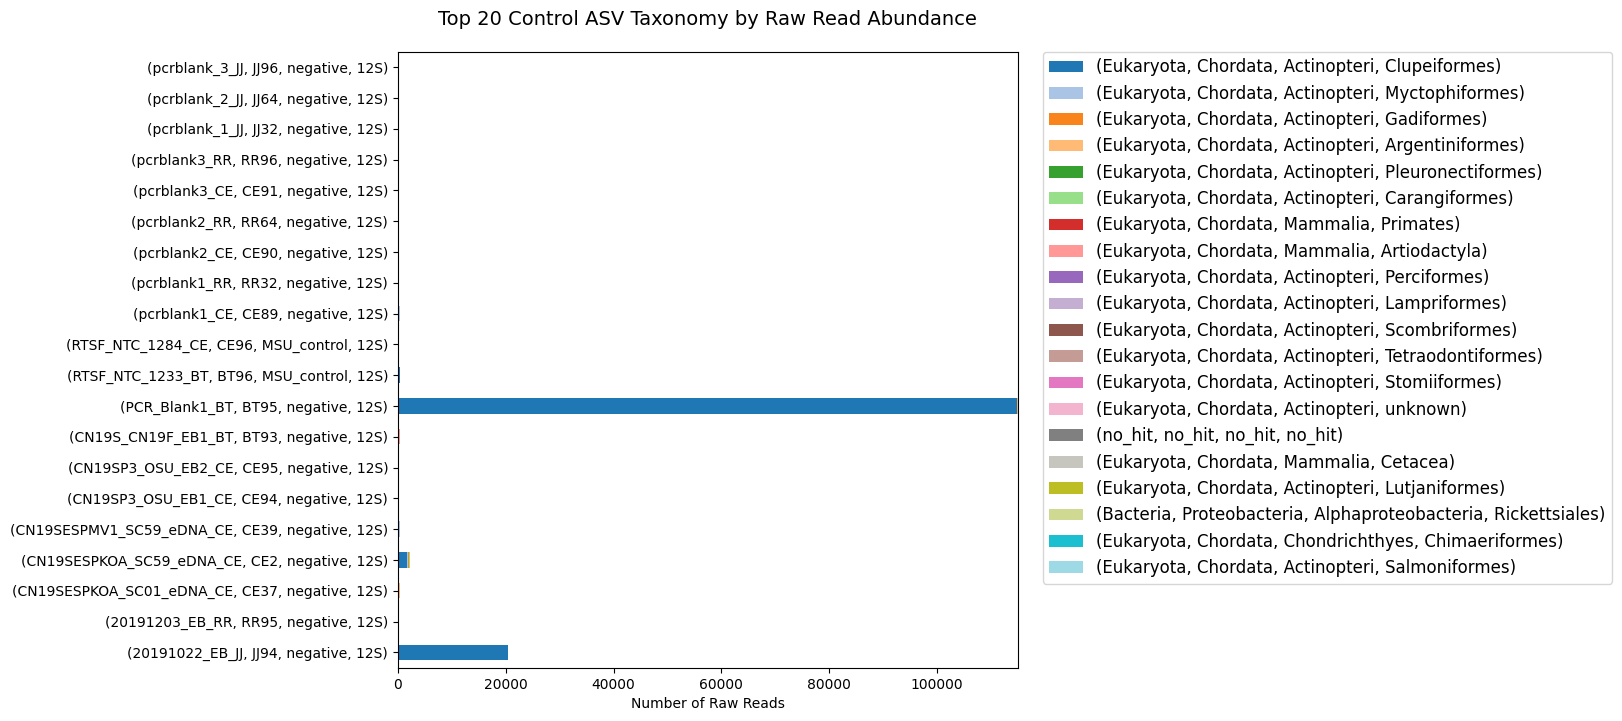

Samples removed as non-environmental:
Index(['CN19SESPKOA_SC60_eDNA_CE', 'CN19SESPKOA_SC59_eDNA_CE',
       'CN19SESPKOA_SC01_eDNA_CE', 'CN19SESPMV1_SC60_eDNA_CE',
       'CN19SESPMV1_SC59_eDNA_CE', 'V4195_CB_eDNA_BT', 'CN19F_CB_V4216_BT',
       'CN19F_CB_V4217_BT', 'V4196_CB_eDNA_BT', 'CN19S_CN19F_EB1_BT',
       'Art_Com1_BT', 'PCR_Blank1_BT', 'RTSF_NTC_1233_BT', 'pcrblank1_RR',
       'pcrblank2_RR', 'ArtComm1_RR', '20191203_EB_RR', 'pcrblank3_RR',
       'pcrblank_1_JJ', 'pcrblank_2_JJ', '20191022_EB_JJ', 'Artcomm2_JJ',
       'pcrblank_3_JJ', 'pcrblank1_CE', 'pcrblank2_CE', 'pcrblank3_CE',
       'ArtComm1_CE', 'ArtComm2_CE', 'CN19SP3_OSU_EB1_CE',
       'CN19SP3_OSU_EB2_CE', 'RTSF_NTC_1284_CE'],
      dtype='object', name='sample_name')
[nan 'MARS' 'OFFMARS_E' 'OFFMARS_S' 'OFFMARS_W' 'OFFMARS_N']
['sample_name', 'FilterID', 'target_gene', 'PlateID', 'library', 'local_time', 'time_label', 'SAMPLING_cruise', 'depth', 'SAMPLING_platform', 'SC', 'ESP', 'SAMPLING_station_number', 'SA

,FilterID,target_gene,PlateID,library,local_time,time_label,SAMPLING_cruise,depth,SAMPLING_platform,SC,...,chlorophyll,bbp470 (count),bbp650 (count),SAMPLING_project,ESP_name,diel,month,day,hour,eventDate
sample_name,,,,,,,,,,,,,,,,,,,,,
CN19SESPMV1_SC58_eDNA_CE,CN19SESPMV1_SC58_eDNA,12S,CE,CE40,2019-05-29 02:42:00,05-29 night,CN19S,17.6279,daphne,58.0,...,2.7972,100.9675,109.2667,CANON,NaN,night,5.0,29.0,2.0,2019-05-29 09:42:00
CN19SESPKOA_SC58_eDNA_CE,CN19SESPKOA_SC58_eDNA,12S,CE,CE3,2019-05-29 12:32:00,05-29 day,CN19S,32.5799,makai,58.0,...,0.5502,83.3809,149.0871,CANON,NaN,day,5.0,29.0,12.0,2019-05-29 19:32:00
CN19SESPKOA_SC57_eDNA_CE,CN19SESPKOA_SC57_eDNA,12S,CE,CE4,2019-05-29 13:47:00,05-29 day,CN19S,202.5248,makai,57.0,...,0.0782,78.4872,146.0477,CANON,NaN,day,5.0,29.0,13.0,2019-05-29 20:47:00
CN19SESPKOA_SC56_eDNA_CE,CN19SESPKOA_SC56_eDNA,12S,CE,CE5,2019-05-29 14:50:00,05-29 day,CN19S,267.6256,makai,56.0,...,0.0833,78.2715,148.8699,CANON,NaN,day,5.0,29.0,14.0,2019-05-29 21:50:00
CN19SESPKOA_SC55_eDNA_CE,CN19SESPKOA_SC55_eDNA,12S,CE,CE6,2019-05-29 23:17:00,05-29 night,CN19S,27.4770,makai,55.0,...,0.3254,80.2178,143.2971,CANON,NaN,night,5.0,29.0,23.0,2019-05-30 06:17:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CN19SESPKOA_SC07_eDNA_CE,CN19SESPKOA_SC07_eDNA,12S,CE,CE32,2019-06-06 00:21:00,06-06 night,CN19S,52.3205,makai,7.0,...,0.1438,77.6797,108.4201,CANON,NaN,night,6.0,6.0,0.0,2019-06-06 07:21:00
CN19SESPKOA_SC06_eDNA_CE,CN19SESPKOA_SC06_eDNA,12S,CE,CE33,2019-06-06 01:24:00,06-06 night,CN19S,102.1287,makai,6.0,...,0.0928,78.7311,111.0515,CANON,NaN,night,6.0,6.0,1.0,2019-06-06 08:24:00
CN19SESPKOA_SC05_eDNA_CE,CN19SESPKOA_SC05_eDNA,12S,CE,CE34,2019-06-06 02:24:00,06-06 night,CN19S,121.5597,makai,5.0,...,0.0858,79.5004,112.9721,CANON,NaN,night,6.0,6.0,2.0,2019-06-06 09:24:00


In [11]:
marker = '12S'

print('#####' +marker + '#####')
# otu table
file = 'CN19S_'+marker+'_Dada2_otu_merged.csv'
print(directory+file)
df = pd.read_csv(directory + file)
df = df.rename(columns= {'Unnamed: 0':'ASV'})
df.set_index('ASV', inplace=True)
otu_all = df.copy()
print('Number ASVs:', len(df.index))
# taxa table
file = 'CN19S_'+marker+'_Dada2_taxa_merged.csv'
print(directory+file)
df = pd.read_csv(directory+file)
df = df.rename(columns= {'Unnamed: 0':'ASV'})
df.set_index('ASV', inplace=True)
taxa_all = df.copy()
print('Number ASVs:', len(df.index))
# metadata
file = 'CN19S_'+marker+'_Dada2_meta_merged.csv'
print(directory+file)
df = pd.read_csv(directory+file)
df.set_index('sample_name', inplace=True)
df['eventDate'] = pd.to_datetime(df['eventDate'])
meta_all = df.copy()
print('Number samples:', len(df.index))

#check what samples don't have date/time values
df = df.sort_values('eventDate')
df=df.loc[df['eventDate'].isna()]
print('Samples without eventDate:')
print(df.index.unique())
# sequence table
file = 'CN19S_'+marker+'_Dada2_seq_merged.csv'
print(directory+file)
df = pd.read_csv(directory +file)
df = df.rename(columns= {'Unnamed: 0':'ASV'})
df.set_index('ASV', inplace=True)
seq_all = df.copy()
print('Number ASVs:', len(df.index))
seq_all.head()
#PLOT
df = meta_all.copy()
#Now just look at pcrblanks
df.loc[df.index.str.contains('_CB'), 'sample_type']='environmental'
df.loc[df.index.str.contains('_BP'), 'sample_type']='environmental'
#df.loc[df.index.str.contains('EB_'), 'sample_type']='environmental'
df.loc[df.index.str.contains('ArtComm'), 'sample_type']='environmental'
df.loc[df.index.str.contains('Artcomm'), 'sample_type']='environmental'

OTUs_in_controls_plot(otu_all, taxa_all, df)

### Remove control samples
df = meta_all.copy()
df1 = df.loc[df['sample_type']!='environmental']
print('Samples removed as non-environmental:')
print(df1.index.unique())
df = df.loc[df['sample_type']=='environmental']
print(df['SAMPLING_station'].unique())
#df = df.loc[df['SAMPLING_station'].isna()==True]  # ALL ESP samples
#df = df.loc[df['SAMPLING_station'].isin(['C1'])==False]
#remove bongo samples
df = df.reset_index()
#df = df.loc[df['sample_name'].str.contains('bongo|Bongo|BONGO')==False]

'''#remove bad libraries
print('Removing bad libraries:')
print(drop_libs)
df = df.loc[df['PlateID'].isin(drop_libs)==False]
'''
print(list(df))
df.set_index('sample_name',inplace=True)

meta_CN19S = df.copy()
otu_CN19S, taxa_CN19S = from_metadata_to_taxareads(meta_CN19S, otu_all, taxa_all)

#remove 'contaminant' taxa
df= taxa_CN19S.copy()
df=df.loc[df['Kingdom'].isin(['Bacteria', 'Archaea'])==False]
#for 12S limit to
if marker == '12S':
    df = df.loc[df['Phylum']=='Chordata']
df=df.loc[df['Class'].isin(['Insecta', 'Arachnida','Amphibia'])==False]
# for consistency, replace Artiodactyla with Cetacea, some marine mammals are being mislabeled in genbank
df['Order'] = df['Order'].str.replace('Artiodactyla', 'Cetacea')
#remove terrestrial bird and mammal families:
fams = ['Hominidae','Canidae','Scincidae','Suidae', 'Bovidae', 'Felidae',
        'Phasianidae','Castoridae','Hirundinidae','Sittidae','Columbidae',
        'Falconidae','Leporidae','Muridae','Fringillidae','Mephitidae',
        'Rhinolophidae','Certhiidae', 'Cervidae']
df = df.loc[df['Family'].isin(fams)==False]
taxa_CN19S_nocontam = df.copy()

#check sequence length
df = pd.concat([df,seq_all ], axis=1, join='inner')
seq_CN19S_nocontam = df[['sequence']]
df['len'] = df['sequence'].str.len()
print('Mean sequence length:',df['len'].mean())
print('Median sequence length:',df['len'].median())
print('Min sequence length:',df['len'].min())
print('Max sequence length:',df['len'].max())
print('STD:',df['len'].std())
print(df['Phylum'].unique())

#from restricted taxa table limit otu table
otu_CN19S_nocontam = from_taxa_to_otutab(taxa_CN19S_nocontam, otu_CN19S)
otu_CN19S_nocontam.head()

#remove any samples with less than 500 reads (total read limit)
# get sample names first
df = otu_CN19S_nocontam.copy()
df = df.T
print('Total samples: ', len(df.index))
df['sum_reads'] = df.sum(axis=1)
df_dropped = df.loc[df['sum_reads']<500]
to_drop = df_dropped.index.tolist()
print('Samples dropped because they contain less than 500 total non-contaminant reads:', to_drop)
print('Total dropped samples: ', len(to_drop))
df = meta_CN19S.copy()
df = df.reset_index()
df = df.loc[df['sample_name'].isin(to_drop)==False]
print('Total samples after dropping: ', len(df.index))
df.set_index('sample_name', inplace=True)
meta_CN19S = df.copy()
#from restricted OTU table to taxa table and metadata table
otu_CN19S_nocontam, taxa_CN19S_nocontam = from_metadata_to_taxareads(meta_CN19S, otu_CN19S_nocontam, taxa_CN19S_nocontam)

#export to csv files for R plotting
folder = '/Users/kpitz/github/MBARI-BOG/CN19S_12S/data/filtered_seq_data/'
dfs = [otu_CN19S_nocontam, taxa_CN19S_nocontam, seq_CN19S_nocontam, meta_CN19S]
names = ['otu', 'taxa', 'seq', 'meta']
for df, name in zip(dfs,names):
    df.to_csv(folder + 'CN19S_'+marker+'_'+name+'_filtered.csv')
    print(folder + 'CN19S_'+marker+'_'+name+'_filtered.csv')
df

### Write fasta file of sequences in project:

In [12]:
df = seq_CN19S_nocontam.copy()
outfile = folder + prefix+'_'+marker+'_seq_filtered.fasta'

seqs = df['sequence'].tolist()
otus = df.index.tolist()

##Write File
resultsFile = open(outfile, "w") #open resultsfile

for i in range(len(otus)):
    resultsFile.write('>' + otus[i])
    resultsFile.write('\n')
    resultsFile.write(seqs[i])
    resultsFile.write('\n')       
print("End")
resultsFile.close()

df.head()

End


,sequence
ASV_1,CACCGCGGTTATACGAGAGACCCTAGTTGATTGAAGCGGCGTAAAG...
ASV_2,CACCGCGGTCAAACGAGCTAGTGCCCGAGCAGATAACTAACGGCGT...
ASV_3,CACCGCGGTTAAACGGGAGGCCCAAGTTGAAAGACAGCGGCGTAAA...
ASV_4,CACCGCGGTTATACGAGCGGCCCAAGTTGATAAAAATCGGCGTAAA...
ASV_5,CACCGCGGTCATACGAGTGTTAGCCCAAGCAGATGGTCAACGGCGT...


### Export table of unique taxonomic annotations

In [13]:
df = taxa_CN19S_nocontam.copy()
df = df.drop_duplicates(levels)
df = df.sort_values(levels)
df = df.reset_index()
df = df.drop('index', axis=1)
df['present'] = 1
df.set_index(levels, inplace=True)
df1 = df.copy()
#merge with ecological categories
file = '/Users/kpitz/github/MBARI-BOG/CN19S_12S/data/metadata/CN19S_Taxa_Categories.csv'
df = pd.read_csv(file)
df = df.set_index(levels)
df = pd.concat([df1,df], axis=1)

#df = df.sort_values('present')
#df = df.sort_values('Ecological_Category')
df.to_csv('/Users/kpitz/github/MBARI-BOG/CN19S_12S/data/metadata/test_Categories.csv')
df

present  \
Kingdom   Phylum   Class       Order              Family         Genus          Species                         
Eukaryota Chordata Actinopteri Alepocephaliformes Platytroctidae Holtbyrnia     s_                        1.0   
                                                                 Sagamichthys   Sagamichthys abei         1.0   
                               Anabantiformes     Channidae      g_             s_                        1.0   
                               Argentiniformes    Argentinidae   g_             s_                        1.0   
                                                  Bathylagidae   Bathylagus     Bathylagus pacificus      1.0   
...                                                                                                       ...   
                   Mammalia    Cetacea            Ziphiidae      g_             s_                        1.0   
                                                  unassigned     g_             s_                        1.0   
                               unassigned         unassigned     g_             s_                        1.0   
                   Myxini      Myxiniformes       Myxinidae      Eptatretus     unassigned                1.0   
                   Actinopteri Gadiformes         Macrouridae    Coryphaenoides unassigned                NaN   

                                                                                                                   Common_name  \
Kingdom   Phylum   Class       Order              Family         Genus          Species                                          
Eukaryota Chordata Actinopteri Alepocephaliformes Platytroctidae Holtbyrnia     s_                               tubeshoulders   
                                                                 Sagamichthys   Sagamichthys abei         Shining tubeshoulder   
                               Anabantiformes     Channidae      g_             s_                    snakeheads (freshwater?)   
                               Argentiniformes    Argentinidae   g_             s_                               marine smelts   
                                                  Bathylagidae   Bathylagus     Bathylagus pacificus         Slender backsmelt   
...                                                                                                                        ...   
                   Mammalia    Cetacea            Ziphiidae      g_             s_                                beaked whale   
                                                  unassigned     g_             s_                                    cetacean   
                               unassigned         unassigned     g_             s_                                      mammal   
                   Myxini      Myxiniformes       Myxinidae      Eptatretus     unassigned                             hagfish   
                   Actinopteri Gadiformes         Macrouridae    Coryphaenoides unassigned                            rattails   

                                                                                                                Ecological_Category  
Kingdom   Phylum   Class       Order              Family         Genus          Species                                              
Eukaryota Chordata Actinopteri Alepocephaliformes Platytroctidae Holtbyrnia     s_                                      mesopelagic  
                                                                 Sagamichthys   Sagamichthys abei                       mesopelagic  
                               Anabantiformes     Channidae      g_             s_                            errant classification  
                               Argentiniformes    Argentinidae   g_             s_                    epipelagic or benthic coastal  
                                                  Bathylagidae   Bathylagus     Bathylagus pacificus                    mesopelagic  
...

### Write fasta file of just Anchovy and which Plates the ASV is in:

In [14]:
print(meta_CN19S['PlateID'].unique())

['CE' 'JJ' 'BT' 'RR']


In [15]:
#otu_CN19S_nocontam, taxa_CN19S_nocontam, seq_CN19S_nocontam, meta_CN19S
#df = seq_CN19S_nocontam.copy()
df = pd.concat([seq_CN19S_nocontam,taxa_CN19S_nocontam ], axis=1)
df = df.loc[df['Genus']=='Engraulis']
cols = ['sequence', 'Genus']
df = pd.concat([df[cols],otu_CN19S_nocontam ], axis=1, join='inner')
df= df.reset_index()
df = df.rename(columns={'index':'ASV'})
df.set_index(['ASV','sequence', 'Genus' ], inplace=True)
df = df.T
df = pd.concat([df, meta_CN19S[['PlateID']]], axis=1)
df = df.groupby('PlateID').sum()

df = df.T
cols = ['ASV','sequence', 'Genus']
for i in range(len(cols)):
    df[cols[i]] = df.index.str[i]

df['label'] =df['ASV']+'_'+ df['Genus']
for i in meta_CN19S['PlateID'].unique():
    df['label'] = df['label'] + '_' + i + ':' + df[i].astype(str)

outfile = folder + prefix+'_'+marker+'_seq_filtered_Engraulis_byPlateID.fasta'

seqs = df['sequence'].tolist()
otus = df.label.tolist()

##Write File
resultsFile = open(outfile, "w") #open resultsfile

for i in range(len(otus)):
    resultsFile.write('>' + otus[i])
    resultsFile.write('\n')
    resultsFile.write(seqs[i])
    resultsFile.write('\n')       
print("End")
resultsFile.close()

df.head()

End


PlateID,BT,CE,JJ,RR,ASV,sequence,Genus,label
"(ASV_1, CACCGCGGTTATACGAGAGACCCTAGTTGATTGAAGCGGCGTAAAGAGTGGTTATGGAGTTTTCCCCTTTAAAGCAGAAAACCTCTCAAACTGTTATACGCACCCAGAGGTTGAAATCCCTCACACGAAAGTGACTTTATATTCGCCTACCAGAACCCACGAAAGCTGGGACA, Engraulis)",1210760,2467060,835600,1161670,ASV_1,CACCGCGGTTATACGAGAGACCCTAGTTGATTGAAGCGGCGTAAAG...,Engraulis,ASV_1_Engraulis_CE:2467060_JJ:835600_BT:121076...
"(ASV_34, CACCGCGGTTATACGAGAGACCCTAGTTGATTGAAGCGGCGTAAAGAGTGGTTATGGAGTTTTTCCCTTTAAAGCAGAAAACCTCTCAAACTGTTATACGCACCCAGAGGTTGAAATCCCTCACACGAAAGTGACTTTATATTCGCCTACCAGAACCCACGAAAGCTGGGACA, Engraulis)",0,149465,4349,13759,ASV_34,CACCGCGGTTATACGAGAGACCCTAGTTGATTGAAGCGGCGTAAAG...,Engraulis,ASV_34_Engraulis_CE:149465_JJ:4349_BT:0_RR:13759
"(ASV_66, CACCGCGGTTATACGAGAGACCCTAGTTGATTGAAGCGGCGTAAAGAGTGGTTATGGAGTTTTCCCCTTTAAAGCAGAAAACCTCTCAAACTGTTATACGCACCCAGAGGTTAAAATCCCTCACACGAAAGTGACTTTATATTCGCCTACCAGAACCCACGAAAGCTGGGACA, Engraulis)",10474,6987,4138,9738,ASV_66,CACCGCGGTTATACGAGAGACCCTAGTTGATTGAAGCGGCGTAAAG...,Engraulis,ASV_66_Engraulis_CE:6987_JJ:4138_BT:10474_RR:9738
"(ASV_73, CACCGCGGTTATACGAGAGACCCTAGTTGACTGAAGCGGCGTAAAGAGTGGTTATGGAGTTTTCCCCTTTAAAGCAGAAAACCTCTCAAACTGTTATACGCACCCAGAGGTTGAAATCCCTCACACGAAAGTGACTTTATATTCGCCTACCAGAACCCACGAAAGCTGGGACA, Engraulis)",0,76005,0,0,ASV_73,CACCGCGGTTATACGAGAGACCCTAGTTGACTGAAGCGGCGTAAAG...,Engraulis,ASV_73_Engraulis_CE:76005_JJ:0_BT:0_RR:0
"(ASV_74, CACCGCGGTTATACGAGAGACCCTAGTTGATTGAAGCGGCGTAAAGAGTGGTTATGGAGTTTTCCCCTTTAAAGCAGAAAACCTCTCAAACTGTTATACGCACCCAGAGGTTGAAACCCCTCACACGAAAGTGACTTTATATTCGCCTACCAGAACCCACGAAAGCTGGGACA, Engraulis)",7426,5499,3247,4159,ASV_74,CACCGCGGTTATACGAGAGACCCTAGTTGATTGAAGCGGCGTAAAG...,Engraulis,ASV_74_Engraulis_CE:5499_JJ:3247_BT:7426_RR:4159
